# 08. PyTorch Paper Replicating

## 0. Get setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.58 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

In [3]:
data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

In [4]:
import os

train_dir = data_path / "train"
test_dir = data_path / "test"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])



train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=transform,
                                                                              batch_size=BATCH_SIZE,
                                                                              num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [5]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2,
         2, 1, 2, 0, 1, 1, 2, 2]))

In [6]:
image, label = images[0], labels[0]

(-0.5, 223.5, 223.5, -0.5)

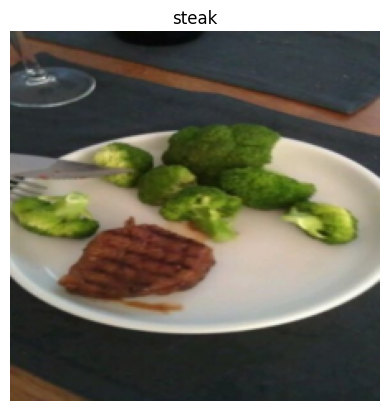

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

## 3. Replicating ViT

## 4. Equation 1: Split data into patches and creating the class, position and path embedding

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* P = patch size
* N = number of paches = (height * width) / p^2
* D = constant latent vector size = embedding dimension

### 4.1 Calculate input and output shapes by hand

In [8]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))
number_of_patches

196

In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

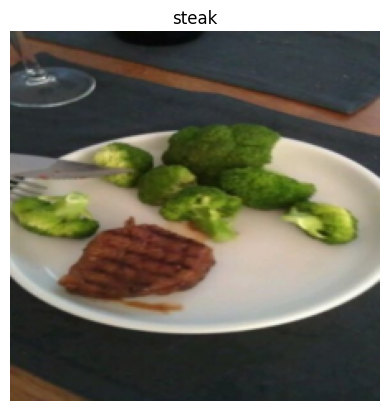

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

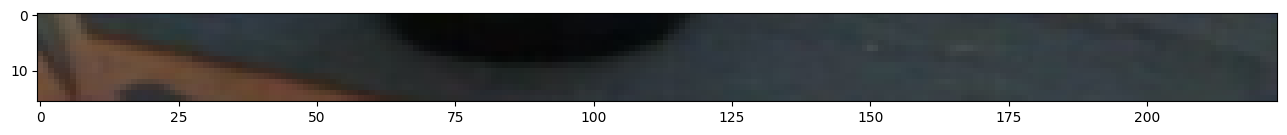

In [11]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

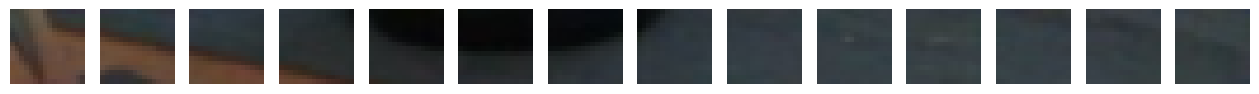

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axis[i].set_xlabel(i+1)
  axis[i].set_xticks([])
  axis[i].set_yticks([])
  axis[i].axis("off")

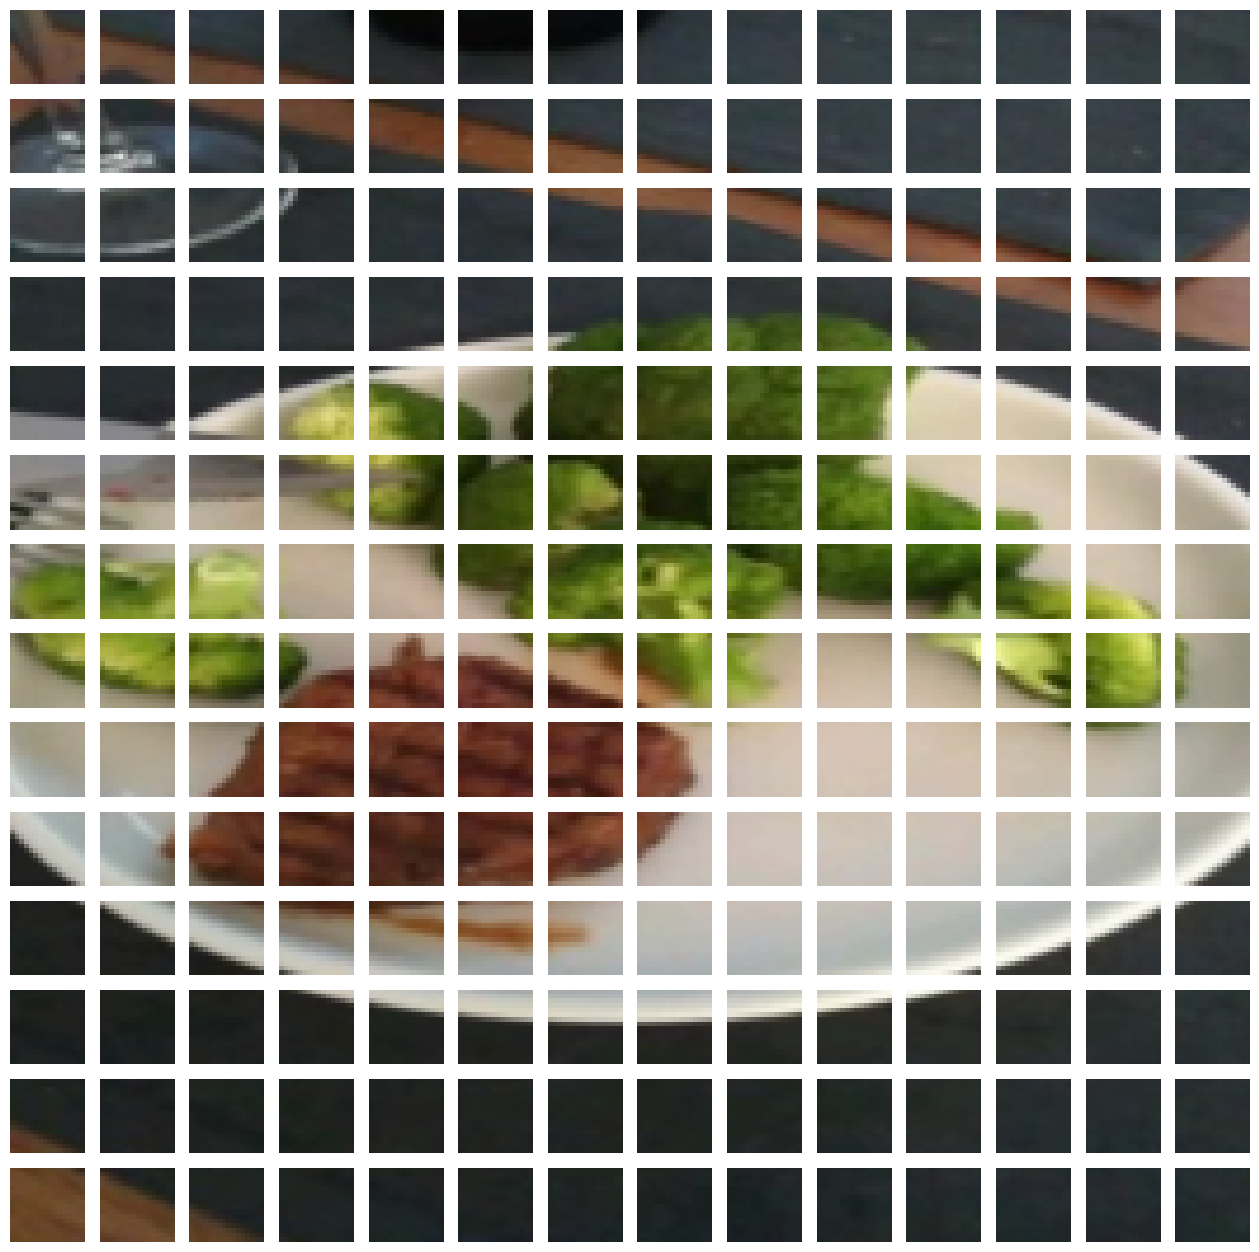

In [13]:
 # Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))

for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axis[i][j].imshow(image_permuted[patch_row:patch_row + patch_size, patch_col:patch_col+patch_size, :])
    axis[i][j].set_xlabel(i+1)
    axis[i][j].set_xticks([])
    axis[i][j].set_yticks([])
    axis[i][j].axis("off")

### 4.3 Creating image patches and turning them into patch embeddings

In [14]:
# Create conv2ddd layer to turn image into patches of learnable feature maps (embedings)
from torch import nn

patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

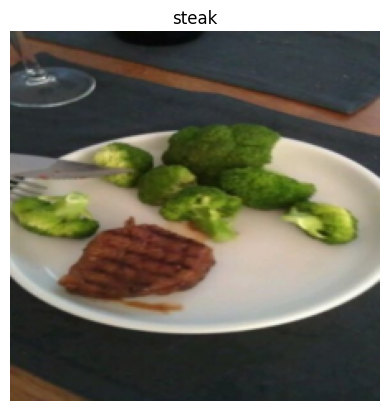

In [15]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [16]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Random indexs: [592, 487, 36, 595, 225]


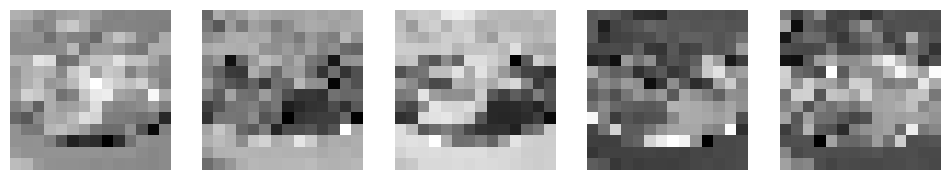

In [17]:
# plot random convolutionla feature maps (embeddings)

import random
random_indexs = random.sample(range(0, 758), k=5)
print(f"Random indexs: {random_indexs}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
for i, idx in enumerate(random_indexs):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.detach().numpy().squeeze(), cmap=plt.cm.gray)
  axs[i].axis("off")


In [18]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[-0.0932, -0.1123, -0.0320, -0.0757, -0.0713, -0.0545, -0.0785,
          -0.1195, -0.1326, -0.1340, -0.1319, -0.1207, -0.1329, -0.1194],
         [-0.1656, -0.0465, -0.1636, -0.0480, -0.1378, -0.1087, -0.0235,
          -0.0987, -0.1361, -0.1288, -0.1348, -0.1455, -0.1293, -0.1279],
         [-0.1428, -0.1342, -0.1113, -0.1091, -0.1109, -0.1039, -0.1457,
          -0.1203, -0.1002, -0.1841, -0.0276, -0.0878, -0.1381, -0.1360],
         [-0.1115, -0.1014, -0.1117, -0.1013, -0.1062, -0.0319, -0.0287,
          -0.0917, -0.0822, -0.0720, -0.1466, -0.1063, -0.1838, -0.1985],
         [-0.0043, -0.0149, -0.0719, -0.1206, -0.0044, -0.1756, -0.0856,
          -0.0851, -0.1137, -0.1494, -0.2510, -0.2984,  0.0687, -0.1130],
         [-0.2625, -0.2083, -0.1211, -0.1114, -0.1367,  0.0020, -0.0483,
          -0.0403, -0.0380, -0.1781, -0.2305, -0.3380, -0.2507, -0.3554],
         [-0.0961, -0.1131, -0.1826, -0.2505, -0.2279, -0.0253, -0.0715,
          -0.0396, -0.0564,  0.0319,  0.0229,

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [19]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
image_out_of_flat = flatten_layer(image_out_of_conv)
image_out_of_flat.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [20]:
single_flattened_feature_map = image_out_of_flat.permute(0, 2, 1)[:, :, 0]

# Plot the flattenend feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis("off")

(-0.5, 195.5, 0.5, -0.5)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [21]:
input_layer = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=768,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0),

    nn.Flatten(start_dim=2, end_dim=-1)
)

In [22]:
out_image = input_layer(image.unsqueeze(dim=0))
out_image.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [25]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, "Image size must be divisible by patch size"
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0, 2, 1)

In [26]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(dim=0))
patch_embedded_image.shape, image.unsqueeze(dim=0).shape

(torch.Size([1, 196, 768]), torch.Size([1, 3, 224, 224]))

### 4.6 Creatign the class token embedding

In [27]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [29]:
# Create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
# Add the class token embeding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)
patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3421,  0.0450, -0.0959,  ...,  0.2075, -0.1516,  0.1448],
          [-0.2911,  0.0612, -0.0374,  ...,  0.1772, -0.1508,  0.1842],
          ...,
          [-0.1633,  0.0353, -0.0754,  ...,  0.1433, -0.0677,  0.0501],
          [-0.1758,  0.0463, -0.0631,  ...,  0.1387, -0.0695,  0.0445],
          [-0.1918,  0.0424, -0.0664,  ...,  0.1569, -0.0771,  0.0433]]],
        grad_fn=<CatBackward0>))

### 4.7 Creating the positionn embedding

In [38]:
number_of_patches = int((height * width)/ patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [40]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.6579, 1.0450, 0.9041,  ..., 1.2075, 0.8484, 1.1448],
          [0.7089, 1.0612, 0.9626,  ..., 1.1772, 0.8492, 1.1842],
          ...,
          [0.8367, 1.0353, 0.9246,  ..., 1.1433, 0.9323, 1.0501],
          [0.8242, 1.0463, 0.9369,  ..., 1.1387, 0.9305, 1.0445],
          [0.8082, 1.0424, 0.9336,  ..., 1.1569, 0.9229, 1.0433]]],
        grad_fn=<AddBackward0>))